In [11]:
from transformers import GPT2LMHeadModel
import torch
from torch import Tensor

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k,v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [25]:
sd_hf['transformer.wte.weight'].view(-1)[:10]

tensor([-0.1101, -0.0393,  0.0331,  0.1338, -0.0485, -0.0789, -0.2398, -0.0895,
         0.0253, -0.1074])

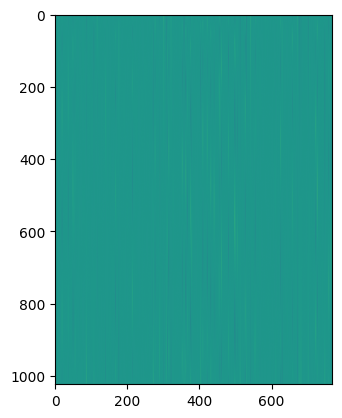

In [34]:
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf['transformer.wpe.weight'])


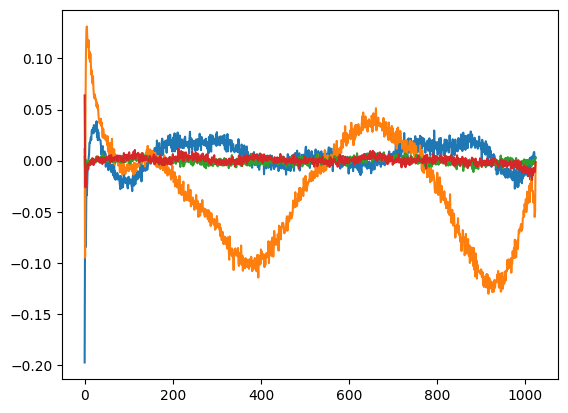

In [42]:
# plt.plot(sd_hf['transformer.wpe.weight'][:, 0])
plt.plot(sd_hf['transformer.wpe.weight'][:, 1])
plt.plot(sd_hf['transformer.wpe.weight'][:, 2])
plt.plot(sd_hf['transformer.wpe.weight'][:, 3])
plt.plot(sd_hf['transformer.wpe.weight'][:, 4])


tensor([[-0.1101, -0.0393,  0.0331,  ...,  0.0870, -0.1298,  0.1102],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0884, -0.1025,  0.0048],
        [-0.1275,  0.0479,  0.1841,  ...,  0.1435,  0.0367,  0.1088],
        ...,
        [-0.1780, -0.1252, -0.0208,  ...,  0.0466,  0.0136, -0.0593],
        [-0.0912,  0.0723,  0.0529,  ...,  0.1767, -0.2070,  0.0547],
        [ 0.1660, -0.1460,  0.1846,  ...,  0.0318,  0.1245,  0.0466]])

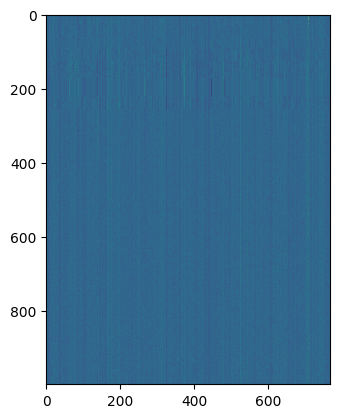

In [81]:
# plt.plot(sd_hf['transformer.wpe.weight'][:, 0])
plt.imshow(sd_hf['transformer.wte.weight'][:1000,])
sd_hf['transformer.wte.weight'][:1000,:500]


In [84]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, and my project will get better with time, but I think there are a lot more things that can help you"},
 {'generated_text': "Hello, I'm a language model, not a language model, so if I don't have a problem, I can fix it by creating new words"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to learn some stuff. I'll try to do some basic programming and just learn better ways"},
 {'generated_text': "Hello, I'm a language model, but I don't believe in grammar. This will work for every language model. You can define it very quickly"},
 {'generated_text': 'Hello, I\'m a language model, a model of how things should be, and then we look at different things as well." I\'d like to'}]

In [11]:
from train import GPT

model = GPT.from_pretrained("gpt2").to('cuda')

loading weights from pretrained gpt: gpt2


In [15]:
model.transformer

ModuleDict(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (h): ModuleList(
    (0-11): 12 x Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GELU(approximate='tanh')
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [1]:
import math
import tiktoken
import torch
from torch import Tensor
import torch.nn.functional as F
device = 'cuda'
enc = tiktoken.get_encoding('gpt2')
indices = torch.tensor(enc.encode('chip is yellow and roses are red')).view(1, -1).to('cuda')
print(indices)

B, T = indices.size()
pos = torch.arange(0, T, dtype=torch.long, device=device) # shape (T)
positional_embeddings = model.transformer.wpe(pos) # type:ignore # position embeddings of shape (T, n_embedding_dimensions) 
token_embeddings = model.transformer.wte(indices) # type: ignore # token embeddings of shape (B, T, n_embedding_dimensions)
x = token_embeddings + positional_embeddings
x.shape
B, T, C = x.size()
block = model.transformer.h[0]
attn = block.attn
config = model.config
attn
qkv: Tensor = attn.c_attn(x)

q, k, v = qkv.split(config.n_embedding_dimensions, dim=2)

k = k.view(B, T, config.n_head, C // config.n_head).transpose(1,2)
q = q.view(B, T, config.n_head, C // config.n_head).transpose(1,2)
v = v.view(B, T, config.n_head, C // config.n_head).transpose(1,2)

att: Tensor = (q @ k.transpose(-2,-1)) * (1.0 /math.sqrt(k.size(-1)))
att = att.masked_fill(attn.bias[:,:,:T,:T] == 0, float('-inf'))  # type: ignore
att = F.softmax(att, dim=-1)

y = att @ v
y = y.transpose(1,2).contiguous().view(B,T,C)
output = attn.c_proj(y) 
output.shape


tensor([[35902,   318,  7872,   290, 42152,   389,  2266]], device='cuda:0')


NameError: name 'model' is not defined

In [54]:
import torch
import torch.nn.functional as F
import math
C = 1
T = 3
q=C*T-1 - torch.arange(C*T).view(T, C).float()
k=torch.arange(C*T).view(T, C).float()
v=torch.arange(C*T).view(T, C).float()
matmul = q @ k.T
scaled = matmul * (1.0 /math.sqrt(k.size(-1))) 
masked = scaled# ignoring masking for now
softmax = F.softmax(masked)
attention = softmax @ v
attention.shape

/var/tmp/ipykernel_21510/1248088519.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = F.softmax(masked)


torch.Size([3, 1])

In [55]:
print(f'{q=}')
print(f'{k=}')
print(f'{v=}')
for v in matmul.tolist():
    print(v)
# print(f'{matmul.tolist()}')
# print(f'{scaled=}')

q=tensor([[2.],
        [1.],
        [0.]])
k=tensor([[0.],
        [1.],
        [2.]])
v=tensor([[0.],
        [1.],
        [2.]])
[0.0, 2.0, 4.0]
[0.0, 1.0, 2.0]
[0.0, 0.0, 0.0]


In [65]:
a = torch.arange(3).view(3,1) + 1
b = torch.arange(3).view(3,1) + 4
a @ b.T

tensor([[ 4,  5,  6],
        [ 8, 10, 12],
        [12, 15, 18]])

In [28]:

# F.softmax(masked, dim=1)

F.softmax(torch.arange(5)/5)

torch.arange(100).view(10,10)

/var/tmp/ipykernel_21510/3677979416.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.arange(5)/5)


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [25]:
x = torch.arange(5).float() / 5

max = x.max()
exp = x.exp() - max


tensor([0.2000, 0.4214, 0.6918, 1.0221, 1.4255])

In [41]:
k.shape, q.shape, v.shape, x.shape, attn.c_attn(x).shape

(torch.Size([1, 12, 8, 64]),
 torch.Size([1, 12, 8, 64]),
 torch.Size([1, 12, 8, 64]),
 torch.Size([1, 8, 768]),
 torch.Size([1, 8, 2304]))

Tokens: ['chip', ' is', ' yellow', ' and', ' roses', ' are', ' red']


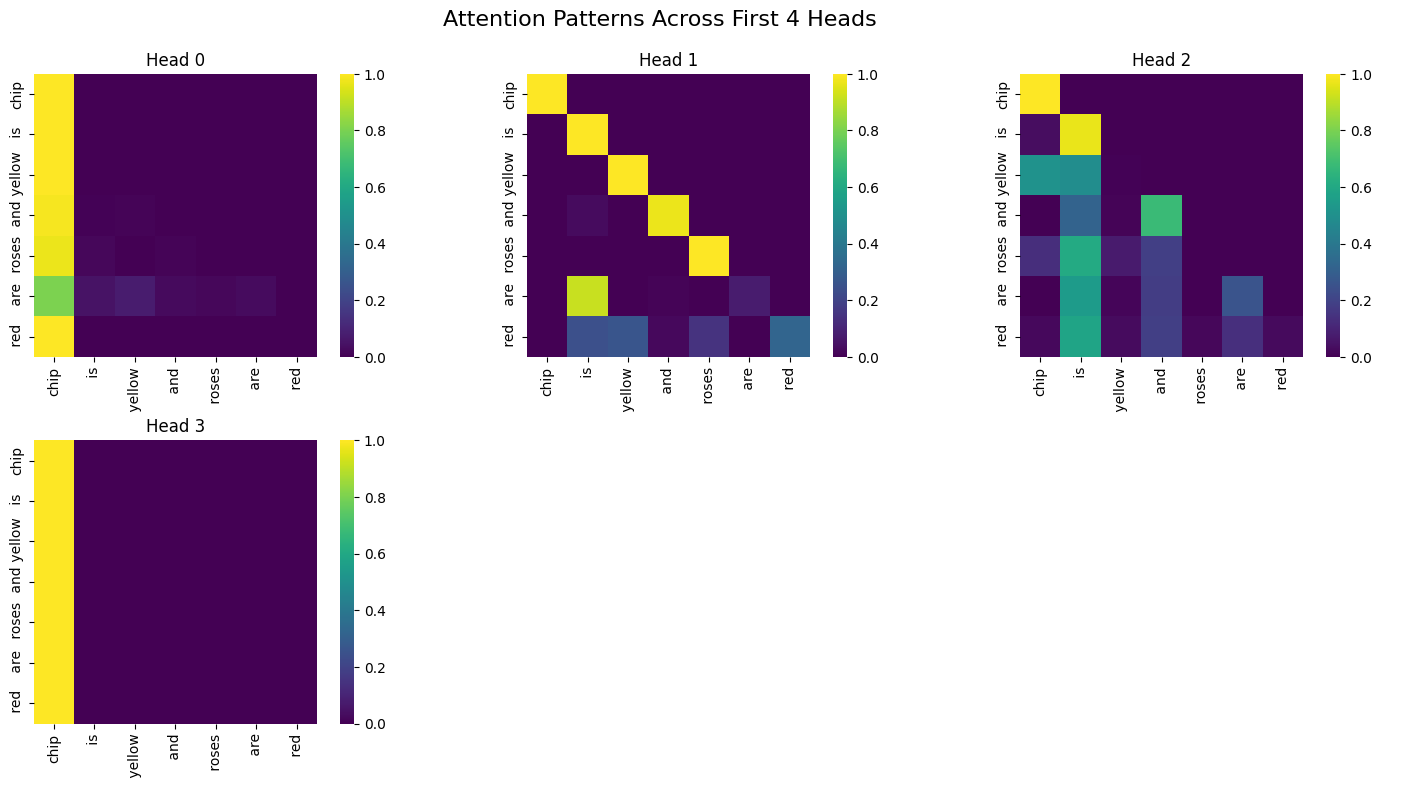

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the number of heads to visualize
n_heads_to_plot = 4  # Change this value to display more or fewer heads

# Decode tokens back to words for visualization
tokens = [enc.decode([int(idx)]) for idx in indices[0].cpu().numpy()]
print("Tokens:", tokens)

# Get attention weights (currently in shape [B, n_head, T, T])
attention_weights = att[0]  # Take the first batch
num_heads = min(n_heads_to_plot, attention_weights.shape[0])

# Calculate layout dimensions
n_cols = min(3, num_heads)
n_rows = (num_heads + n_cols - 1) // n_cols

# Create a figure to display attention for the first n heads
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows * n_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Handle the case when there's only one subplot

# Plot heatmap for each attention head
for h in range(num_heads):
    ax = axes[h]
    attention_head = attention_weights[h].cpu().detach().numpy()
    
    # Create heatmap
    sns.heatmap(attention_head, annot=False, cmap='viridis', ax=ax, square=True)
    
    # Set labels
    ax.set_title(f"Head {h}")
    ax.set_xticks(np.arange(len(tokens)) + 0.5)
    ax.set_yticks(np.arange(len(tokens)) + 0.5)
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)

# Hide any unused subplots
for i in range(num_heads, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle(f"Attention Patterns Across First {num_heads} Heads", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Word indices: {'yellow': 2, 'roses': 4, 'red': 6}


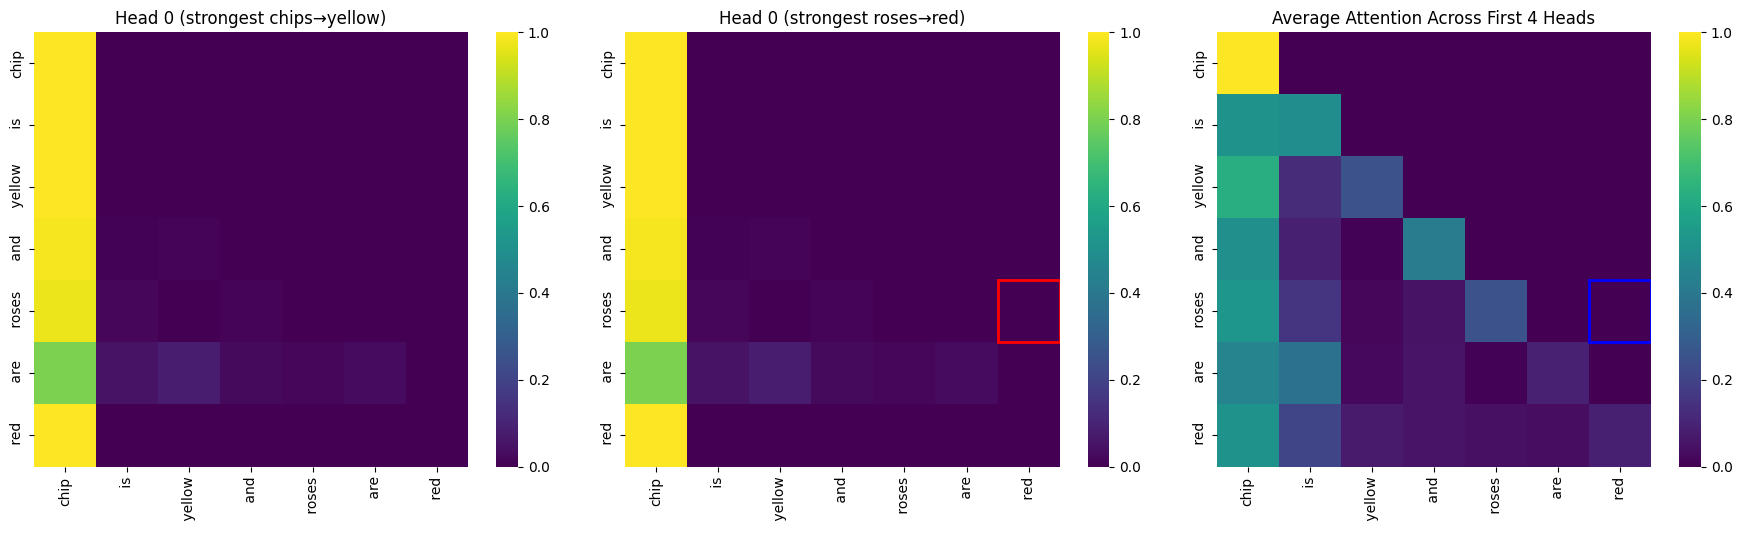

In [50]:

# Function to plot specific attention relationships
def plot_specific_relationships(n_heads_to_analyze=None):
    # If n_heads_to_analyze is None, use all heads for finding the best patterns
    if n_heads_to_analyze is None:
        n_heads_to_analyze = attention_weights.shape[0]
    else:
        n_heads_to_analyze = min(n_heads_to_analyze, attention_weights.shape[0])
    
    # Find indices for the words of interest
    words_of_interest = ["chips", "yellow", "roses", "red"]
    word_indices = {}
    
    for i, token in enumerate(tokens):
        for word in words_of_interest:
            if word in token:
                word_indices[word] = i
    
    print(f"Word indices: {word_indices}")
    
    # Plot attention specifically for these relationships
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot chips -> yellow attention
    head_idx = np.argmax([
        attention_weights[h, word_indices.get("chips", 0), word_indices.get("yellow", 0)].item() 
        for h in range(n_heads_to_analyze)
    ])
    
    # Best head for chips -> yellow
    ax = axes[0]
    attention_head = attention_weights[head_idx].cpu().detach().numpy()
    sns.heatmap(attention_head, cmap='viridis', ax=ax, square=True)
    ax.set_title(f"Head {head_idx} (strongest chips→yellow)")
    ax.set_xticks(np.arange(len(tokens)) + 0.5)
    ax.set_yticks(np.arange(len(tokens)) + 0.5)
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    
    # Highlight chips -> yellow
    if "chips" in word_indices and "yellow" in word_indices:
        rect = plt.Rectangle(
            (word_indices["yellow"], word_indices["chips"]), 
            1, 1, fill=False, edgecolor='red', lw=2
        )
        ax.add_patch(rect)
    
    # Best head for roses -> red
    head_idx = np.argmax([
        attention_weights[h, word_indices.get("roses", 0), word_indices.get("red", 0)].item() 
        for h in range(n_heads_to_analyze)
    ])
    
    ax = axes[1]
    attention_head = attention_weights[head_idx].cpu().detach().numpy()
    sns.heatmap(attention_head, cmap='viridis', ax=ax, square=True)
    ax.set_title(f"Head {head_idx} (strongest roses→red)")
    ax.set_xticks(np.arange(len(tokens)) + 0.5)
    ax.set_yticks(np.arange(len(tokens)) + 0.5)
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    
    # Highlight roses -> red
    if "roses" in word_indices and "red" in word_indices:
        rect = plt.Rectangle(
            (word_indices["red"], word_indices["roses"]), 
            1, 1, fill=False, edgecolor='red', lw=2
        )
        ax.add_patch(rect)
    
    # Plot combined attention for both relationships
    ax = axes[2]
    
    # Average across analyzed heads
    avg_attention = attention_weights[:n_heads_to_analyze].mean(0).cpu().detach().numpy()
    sns.heatmap(avg_attention, cmap='viridis', ax=ax, square=True)
    ax.set_title(f"Average Attention Across First {n_heads_to_analyze} Heads")
    ax.set_xticks(np.arange(len(tokens)) + 0.5)
    ax.set_yticks(np.arange(len(tokens)) + 0.5)
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    
    # Highlight both relationships
    if "chips" in word_indices and "yellow" in word_indices:
        rect = plt.Rectangle(
            (word_indices["yellow"], word_indices["chips"]), 
            1, 1, fill=False, edgecolor='red', lw=2
        )
        ax.add_patch(rect)
    
    if "roses" in word_indices and "red" in word_indices:
        rect = plt.Rectangle(
            (word_indices["red"], word_indices["roses"]), 
            1, 1, fill=False, edgecolor='blue', lw=2
        )
        ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

# Visualize specific relationships using the same number of heads
plot_specific_relationships(n_heads_to_plot)

torch.Size([5, 5])
i=0 loss=tensor(1.3162, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[-0.0519, -0.3584, -0.3213,  0.3791,  0.2220],
        [-0.0437, -0.4262,  0.0864,  0.3461,  0.3980],
        [ 0.4384,  0.0902, -0.1359,  0.3368, -0.3471],
        [ 0.3081, -0.4042, -0.2838, -0.3297, -0.1183],
        [-0.0528, -0.1768,  0.3860, -0.3843,  0.2900]], requires_grad=True)
i=1 loss=tensor(1.3162, grad_fn=<MeanBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

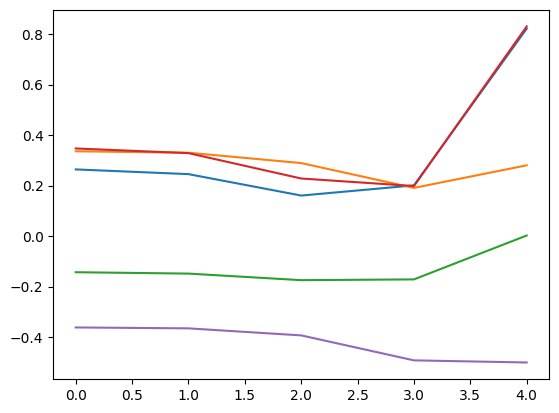

In [51]:
import torch
from matplotlib import pyplot as plt
%matplotlib inline
from torch import nn

T, C = 5,1
a = torch.arange(T*C).float().view(T,C)- 5
l1 = nn.Linear(T, C*T)
gelu =nn.GELU(approximate='tanh')
l2 = nn.Linear(C*T, T)
a = a+ l1(a.T)
a = gelu(a)
a = a+l2(a)
plt.plot(a.detach().numpy())

print(a.shape)
le = 0.01

for i in range(10):
    loss = ((-1 - a) **2).mean()
    print(f'{i=} {loss=}')
    loss.grad = None
    loss.backward()
    print(l1.weight)


